In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import torch 
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.autograd import Variable
import time
import copy
from PIL import Image
input_path = "../input/data-chamber/DATA_CHAMBER_2021/" 


In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    
     # Override phương thức __getitem__. Phương thức dùng để đọc, xử lí dữ liệu, nhãn và trả về dữ liệu -> model
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Cài đặt mô hình (có sử dụng pretrained)

In [4]:
def initialize_model(model_name, num_classes, feature_extract = False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg16_bn":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn().load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = vgg16.classifier[6].in_features
        features = list(vgg16.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, len(num_classes))]) # Add our layer with 4 outputs
        vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model('resnet50',3,feature_extract = False, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Resize ảnh về cùng kích cỡ và augmentation

In [5]:
data_transforms = {
    'train': transforms.Compose([        #Tập train
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(), #augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([    #Tập test
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(), #augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

#Load dữ liệu

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', data_transforms['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', data_transforms['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

#Chia tập ảnh thành cách batch
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2),  # for Kaggle, Run 2 processes simultaneously
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2)  # for Kaggle
}
class_names = image_datasets['train'].classes

# See some statistics
print(dataloaders)
len(dataloaders['train'])

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f783b285950>, 'validation': <torch.utils.data.dataloader.DataLoader object at 0x7f783b285f50>}


210

****Visualize a few images****

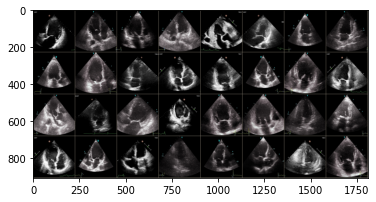

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# imshow(out, title=[class_names[x] for x in classes])

# 2. General functions to train and visualize


Here we use a general function to train a model. It includes:
* Scheduling the learning rate
* Saving the best model.

In [7]:
#Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, is_inception=False):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())    #Save the status of pretrained Model
    best_acc = 0.0
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','validation']:
            train_batches = len(dataloaders[phase])
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0      #variable used to calculate loss function
            running_corrects = 0    #variable used to calculate accuracy

            # Iterate over data.
            # inputs==pixels
            # labels==labels of frame
            # _ == file's path
            for i,(inputs, labels,_) in enumerate(dataloaders[phase]):
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    if is_inception and phase == 'train':  #only for inception model
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)             #predicted output
                        loss = criterion(outputs, labels)   #label==actual output
                    
                    _, preds = torch.max(outputs, 1) #choose the highest probability

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()    #Update weights for model

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_values.append(epoch_loss)
            acc_values.append(epoch_acc)
            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

Visualizing the model predictions
A generic function to display predictions for a few images.

In [8]:
#Predict function
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels,_) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 3. Transfer learning: feature extractor

ResNet stands for Residual Network. It is an innovative neural network that was first introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 computer vision research paper titled ‘Deep Residual Learning for Image Recognition’.

ResNet has many variants that run on the same concept but have different numbers of layers. Resnet50 is used to denote the variant that can work with 50 neural network layers.

# 4. Train and evaluate

In [9]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
# y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [10]:

from torch.optim import lr_scheduler
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

Using CUDA


In [11]:
model_ft,acc,loss = train_model(model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4, is_inception=False) # As an example, only show the results of 4 epoch

Epoch 1/4
----------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training batch 210/210
train Loss: 0.2278 Acc: 0.9101
Training batch 51/51
validation Loss: 0.6398 Acc: 0.8625

Epoch 2/4
----------
Training batch 210/210
train Loss: 0.0102 Acc: 0.9964
Training batch 51/51
validation Loss: 0.7851 Acc: 0.8040

Epoch 3/4
----------
Training batch 210/210
train Loss: 0.0026 Acc: 0.9996
Training batch 51/51
validation Loss: 0.6168 Acc: 0.8276

Epoch 4/4
----------
Training batch 210/210
train Loss: 0.0010 Acc: 1.0000
Training batch 51/51
validation Loss: 0.6209 Acc: 0.8214

Training complete in 5m 2s
Best val Acc: 0.862477


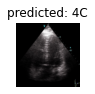

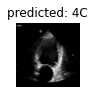

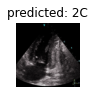

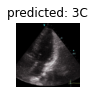

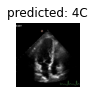

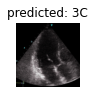

In [12]:
visualize_model(model_ft)

plt.ioff()
plt.show()

# plot history

In [13]:
def plot_history(history,loss,acc): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(loss, 'r', label="training loss")
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss', color='r')
    ax1.legend(loc="lower right", fontsize=9)    
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(acc, 'b', label="training acc")
    ax2.legend(loc="upper right", fontsize=9)
    ax2.set_ylabel('acc', color='b')        
    ax2.tick_params('y', colors='b')


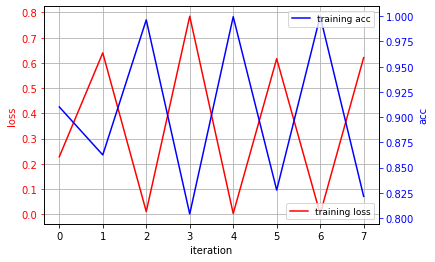

In [14]:
plot_history(model_ft,loss,acc)

# Acuracy score in test dataset
Frame accuracy

In [15]:
y_true,y_pred,vid_id = test_model(model_ft, criterion, optimizer_conv)
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.8462974486621033

Create a dataframe from ours image label, predictions and video_id of each image (frame)

In [16]:
import pandas as pd
import glob


df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

vid_list = list(set(df['vid_id'].values))
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)

Calculate video acc base on voting scheme

Dominant predicted frame's labels will be voted to be video's labels

In [17]:
#Tinh toan do chinh xac doi voi video dua tren co che Voting
#Chon trong nhieu video xem nhan(label) nao xuat hien nhieu nhat
accuracy_score(y_true,y_pred)

0.8461538461538461